![title](img/logo.png)

# Biometrics System Concepts
## Assignment 1: Evaluating performance of biometric systems
<b>Name</b>: Bram Vrints |
<b>Student-nr</b>: r0884391 |
<b>Date</b>: February 14, 2026
---

In this assignment we focus on evaluating the performance of any biometric system in a verification and identification setting. 

Before you get started you should be able to properly distinguish verification from identification and know the corresponding validation procedures. If this is not the case for you yet, **review the lecture notes!** We will give a short recap to refresh your memory: 
* **VERIFICATION** (a.k.a. authentication): Authenticating a claimed identity (is this person who he/she claims to be?).

* **IDENTIFICATION**: Associate a particular individual with an identity (who is this unidentified individual?).

This document is structured as follows:

- [I. Reading the data](#I.-Reading-the-data)
- [II. Validation of verification system](#II.-Validation-of-verification-system)
- [III. Validation of identification system](#III.-Validation-of-identification-system)
- [IV. Assignment Instructions](#IV.-Assignment-Instructions)


Code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of algorithmic components). The code examples in this assignment are just sekeleton code,  **adapt where needed! And try to keep things structured!** 

In [1]:
# Install and import the required python packages to run this notebook. Feel free to add more packages whenever needed.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, det_curve, f1_score, accuracy_score, precision_recall_curve
# the following meta-command is required to get plots displayed in notebooks
%matplotlib inline

# package for data analysis with fast and flexible data structures
import pandas as pd

# package to show a nice graphical progress-bar for lengthy calculations
# docu and installation on https://tqdm.github.io
# if you have difficulties installing this package: 
# - make sure your jupyter lab is up to date
# - https://github.com/tqdm/tqdm/issues/394#issuecomment-384743637
# - consider just leaving it out (just remove the 'tqdm_notebook' in the code)
from tqdm.notebook import tqdm as tqdm_notebook
import pickle
print("Done")

Done


<div class="alert alert-block alert-info">
<b>Tip:</b> 
Many operations have already been implemented in <a href="https://docs.scipy.org/doc/numpy/index.html">SciPy</a>, feel free to use them or any other unless explicitely stated not to in the assignment.</div>

## I. Reading the data
In this assignment we focus on the validation of a pre-exising biometric system. We will make use of synthetic similarity scores of four different biometric systems. This bypasses all steps of preprocessing, feature extraction and matching and allows us to concentrate on the score evaluation procedures. The scores are the result of comparing an enrolled user's image with the score of the same (genuine scores) or another user (impostor scores). The data can be found in the .csv files in the `./data/` subfolder. 

In this code example we will compare the performance of four biometric systems. These systems are referred to as `system1`, `system2`, `system3` and `system4` respectively in both code and text. 

<div class="alert alert-block alert-info">
<b>Tip:</b> 
For each question, make sure to <b> compare the results for the different systems</b>!!! Mention which system performs the best/worst and why.</div>

### 1.1. Loading the similarity matrix and reading the genuine and impostor scores
We provide you with the code to read the scores from the files (normally you can leave this code as-is).

The code consists of 2 steps that are executed for all the systems: 
1. Scores are converted to similarity matrices. To simplify the task we have provided you with the similarity matrices. You need to load the similarity matrices with the genuine scores on the diagonal and the impostor scores on the off-diagonal elements.  
2. Convert the original scores to a linear list of scores with associated labels of genuine or impostor (simplifies use of [scikit-learn](https://scikit-learn.org/stable/index.html))



In [2]:
# STEP 1: loading the similarity matrices for the four systems
with open('./data/system1_similarity_matrix.csv','rb') as f:
    system1_similarity_matrix = pickle.load(f)
with open('./data/system2_similarity_matrix.csv','rb') as f:
    system2_similarity_matrix = pickle.load(f)
with open('./data/system3_similarity_matrix.csv','rb') as f:
    system3_similarity_matrix = pickle.load(f)
with open('./data/system4_similarity_matrix.csv','rb') as f:
    system4_similarity_matrix = pickle.load(f)
print(type(system1_similarity_matrix))
print(system1_similarity_matrix)


# STEP 2: convert to genuine and impostor scores, the *_genuine_id provides a mask for the genuine scores
def sim2scores(similarity_matrix):
    # use .values to access as numpy array
    np_similarity_matrix = similarity_matrix

    # grab elements on the diagonal
    genuine_scores = np.diag(np_similarity_matrix)

    # mask elements that are on the diagonal, retain non-diagonal elements
    imposter_scores =  np_similarity_matrix[~np.eye(np_similarity_matrix.shape[0],dtype=bool)]

    # store in one single list of scores as required for the classification validation procedures
    scores = np.append(np.array(genuine_scores), np.array(imposter_scores))

    # normalize to [0,1] range, 0 corresponding to minimal similarity
    scores = (scores - scores.min())/(scores.max()-scores.min())

    ## add the genuine and imposter labels

    # tag genuine combinations as label 1 and imposter combinations as 0

    genuine_id = np.zeros_like(scores)
    genuine_id[0:genuine_scores.shape[0]] = 1

    return(genuine_id, scores)


system1_genuine_id, system1_scores = sim2scores(system1_similarity_matrix)
system2_genuine_id, system2_scores = sim2scores(system2_similarity_matrix)
system3_genuine_id, system3_scores = sim2scores(system3_similarity_matrix)
system4_genuine_id, system4_scores = sim2scores(system4_similarity_matrix)
print("Done")

<class 'numpy.ndarray'>
[[ 6.48730361  0.69352768 -3.86501703 ...  2.12183612 -0.84331811
   2.29475023]
 [ 3.77365119  5.81647308  1.97903324 ... -0.54378096 -0.24531316
   0.69868077]
 [-1.80004577 -1.60213216  5.84154847 ... -0.58968609  0.7481939
  -0.9206928 ]
 ...
 [ 0.09193256 -0.16410043  0.93337656 ...  5.97911264  3.54499178
   1.48657273]
 [ 2.65662266 -1.28256359  2.09351615 ... -0.87710247  6.10616113
   0.65302102]
 [ 3.19788089  1.00973575  4.36628529 ...  3.37207976  1.62679603
   5.9439135 ]]
Done


<div class="alert alert-block alert-info">
<b>Tip:</b> 
In this assignment we focus only on evaluating biometric systems. It is in your best interest to write your code such that it can easily be reused in the upcoming assignments, where you will have to develop entire biometric system pipelines.</div>

## II. Validation of verification system

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

The performance of a verification scenario can be expressed in a number of ways (see [Jain et al.][1] section 1.4.1.1 for more information). In essence one has a binary classification problem: is it the claimed identity or not? 

We denote our classes as:
<ol start="0">
  <li>Impostor (False),</li>
  <li>Genuine (True).</li>
</ol>

Furthermore, we represent the set of scores as s, the imposter event as $I$ and a genuine event as $G$.

### 1. Evaluation using FMR, FRR, ROC and Precision/Recall curves

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)



#### 1.1 Genuine and impostor score distributions
Given the genuine and impostor scores (from section I), we can plot the imposter $p(s | I)$ and genuine $p(s | G)$ distribution to gain some first insights in the system. The result should look something like this:

<p align="center">
    <img src="img/ScoreDistributions.png" width="250" height="auto"/>
</p>


<div class="alert alert-block alert-success">
<b>Q1: </b> Score distributions
<ul>
  <li>Plot the genuine and impostor score distributions in a single plot for the four systems.</li>
  <li>Do you need to normalize the distributions? Why (not)?</li>
  <li>Describe qualitatively this combined plot. Which system performs the best based on this plot?</li>
  <li>Which system corresponds to which of the following descriptions?</li>
  <ol type = 'A'>
    <li> small inter-user distance, small intra-user variation </li>
    <li> small inter-user similarity, small intra-user variation </li>
    <li> large inter-user similarity, large intra-user variation </li>
    <li> large inter-user distance, large intra-user variation </li>
  </ol>
</ul>  
</div>

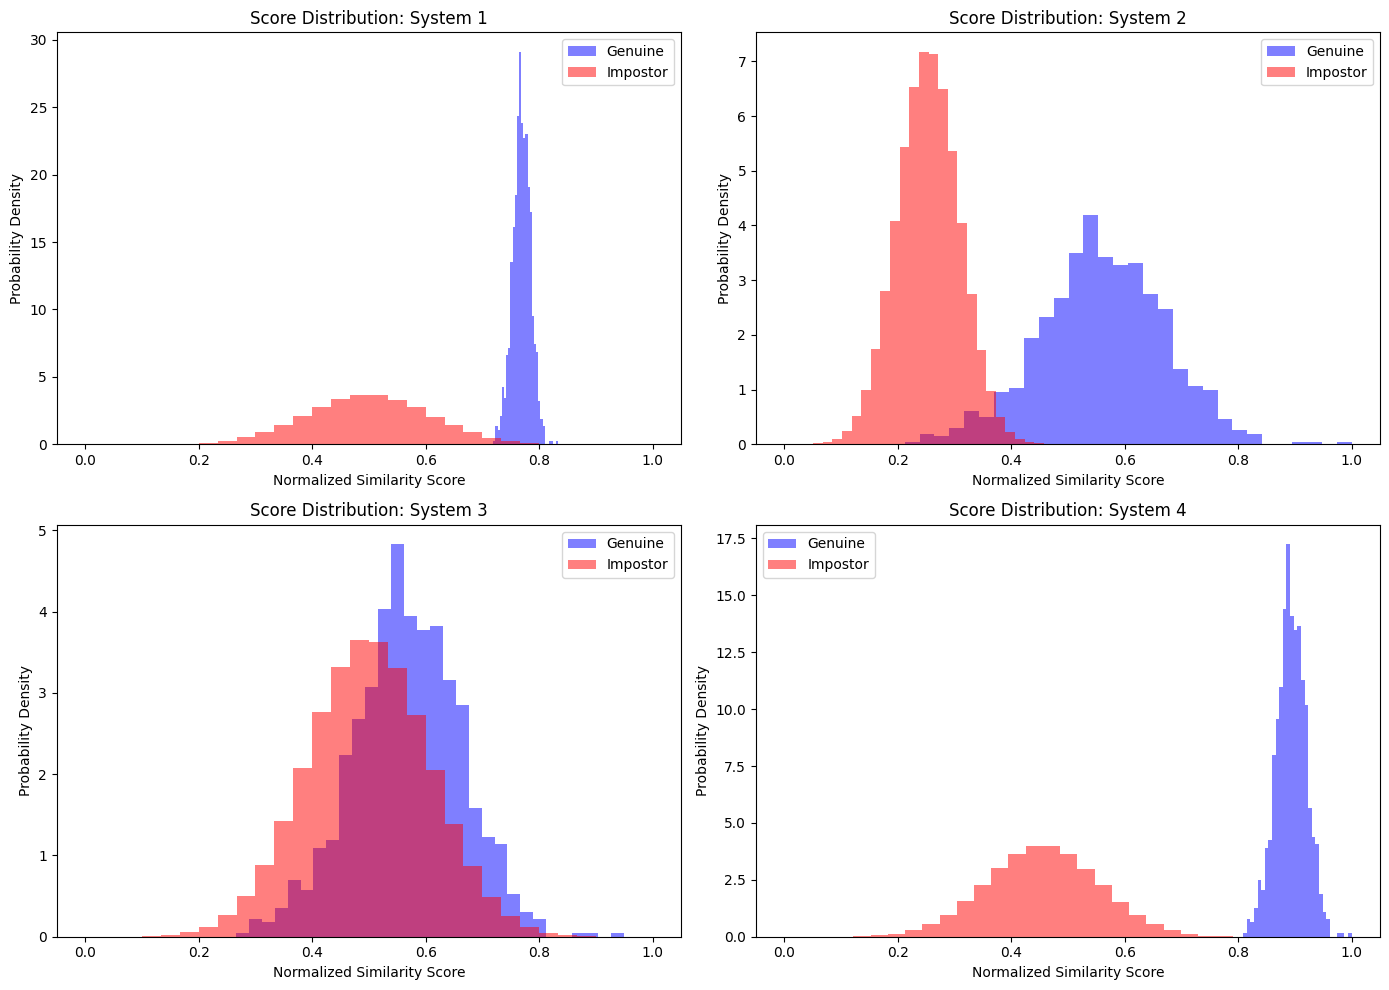

In [3]:
"""Plot the genuine and imposter score distributions."""
systems_data = [
    ("System 1", system1_scores, system1_genuine_id),
    ("System 2", system2_scores, system2_genuine_id),
    ("System 3", system3_scores, system3_genuine_id),
    ("System 4", system4_scores, system4_genuine_id)
]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, scores, labels) in enumerate(systems_data):
    # Separate the scores using the labels
    # Genuine labels are 1, Impostor labels are 0
    gen_scores = scores[labels == 1]
    imp_scores = scores[labels == 0]
    
    # Plot Histograms
    # density=True normalizes the y-axis so the area under the histogram is 1
    axes[i].hist(gen_scores, bins=30, alpha=0.5, label='Genuine', color='blue', density=True)
    axes[i].hist(imp_scores, bins=30, alpha=0.5, label='Impostor', color='red', density=True)
    
    axes[i].set_title(f'Score Distribution: {name}')
    axes[i].set_xlabel('Normalized Similarity Score')
    axes[i].set_ylabel('Probability Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

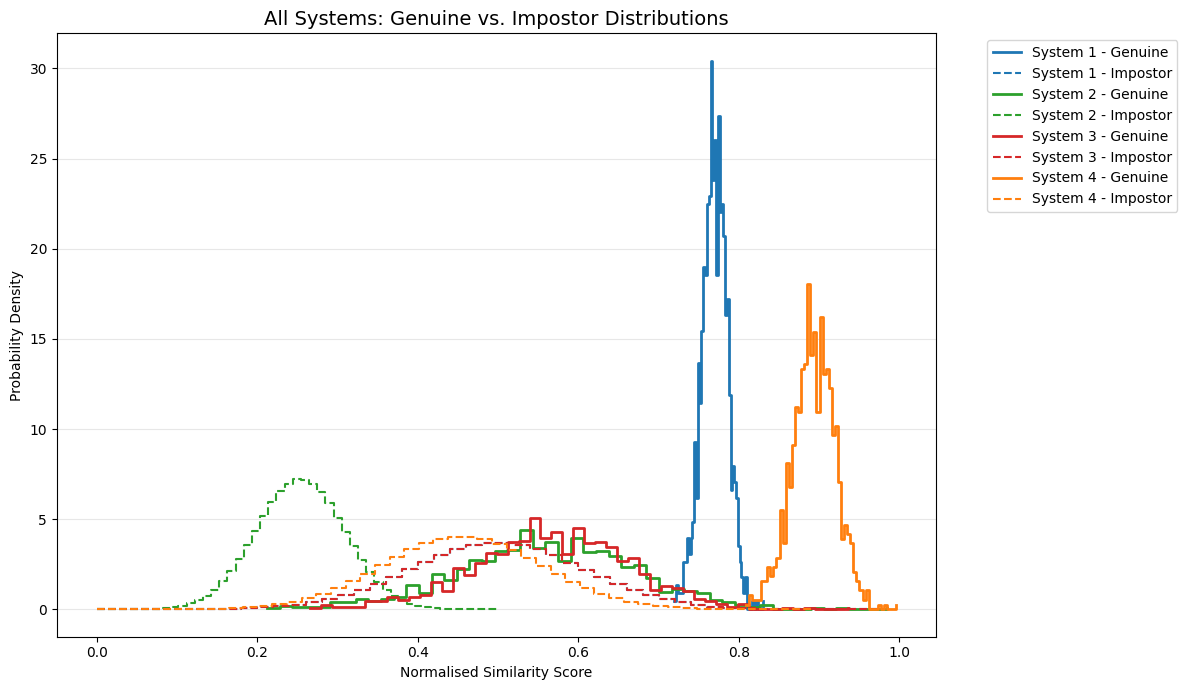

In [4]:
import numpy as np
import matplotlib.pyplot as plt

systems_list = [
    ("System 1", system1_scores, system1_genuine_id, 'tab:blue'),
    ("System 2", system2_scores, system2_genuine_id, 'tab:green'),
    ("System 3", system3_scores, system3_genuine_id, 'tab:red'),
    ("System 4", system4_scores, system4_genuine_id, 'tab:orange')
]

plt.figure(figsize=(12, 7))

for name, scores, labels, color in systems_list:
    gen_scores = scores[labels == 1]
    imp_scores = scores[labels == 0]
    
    # Calculate histogram for Genuine
    counts_g, bins_g = np.histogram(gen_scores, bins=50, density=True)
    # Calculate histogram for Impostor
    counts_i, bins_i = np.histogram(imp_scores, bins=50, density=True)
    
    # Manually plot steps to ensure color consistency
    plt.step(bins_g[:-1], counts_g, where='post', color=color, 
             label=f'{name} - Genuine', linewidth=2)
    
    plt.step(bins_i[:-1], counts_i, where='post', color=color, 
             label=f'{name} - Impostor', linewidth=1.5, linestyle='--')

# Formatting per assignment requirements
plt.title('All Systems: Genuine vs. Impostor Distributions', fontsize=14)
plt.xlabel('Normalised Similarity Score')
plt.ylabel('Probability Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Answers to Q1:

- Yes, you have to normalise, because generally there are more impostor samples than genuine samples. There is a data imbalance. If you don't normalise, the impostor distribution will be many times larger than the genuine distribution, and the plot will provide no insight. Furthermore, it allows to compare different biometric systems on a consistent scale. You can say that it is analogous to z-score normalisation in statistics.

- The best system is the one where the genuine and imposter distribution are the furthest apart from each other. Ideally, they have no overlap so that the False Non Match Region and the False Match Region are both as small as possible. When looking at the plot, it is clear that System 4 performs best, because there is no overlap between the genuine and impostor distribution. System 3 performs the worst, because it has the largest overlap.

- The system with small inter-user distance and small inter-user variation is System 1. The genuine distribution is narrow and has a high peak, indicating small intra-user variation. This means that the biometric traits it uses are permanent, i.e. they do not change over the lifetime of the individual. Furthermore, the inter-user distance is small in System 1, because the impostor distribution overlaps with the genuine distribution, indicating that there is a high similarity or low uniqueness between persons.
- The system with small inter-user similarity and small intra-user variation is System 4. The genuine distribution is narrow and has a high peak, indicating small intra-user variation. The inter-user similarity is small, because the distance between the peaks of the impostor and genuine distribution is high. There is no overlap between them.
- The system with large inter-user similarity and large intra-user variation is System 3. The genuine distribution is wide, so there is a lot of itra-user variation. The inter-user similarity is high, because there is a lot of overlap between the genuine and the impostor distribution. The distance between them is small, so there is a high inter-user  similarity.
- The system with a large inter-user distance and large intra-user variation is System 2. The genuine distributino is wide, indicating a high intra-user variation. The distance between the peaks of the genuine and the impostor distribution is realtively large, and there is few overlap between the genuine and impostor distribution.

#### 2. FMR, FRR and Receiver Operating Characteristic (ROC) curve

The 'false accept' and 'false reject' regions in the illustration above are quantified using the False Match/Acceptance Rates (FMR/FAR) and False Non-Match/Rejections Rates (FNMR/FRR). The FMR and FNMR can easily be computed given the previously calculated probability distributions and a threshold value $\eta$. Practically this boils down to a counting problem, having $\mathcal{I}$ the indicator function (return 1 if x is true, else 0) we can compute:
$$
FMR(\eta) = p(s \geq \eta | I) \approx \frac{1}{|I|} \sum_{s \in I} \mathcal{I}(s \geq \eta),
$$
$$
FRR(\eta) = p(s < \eta | G) \approx \frac{1}{|G|} \sum_{s \in G} \mathcal{I}(s < \eta).
$$

We can also compute the Genuine Acceptance Rate (GAR)/True Match Rate (TMR) as:
$$
GAR(\eta) = p(s \geq \eta | G) = 1 - FRR(\eta).
$$

Note that choosing a threshold is always a tradeoff between FMR and FNMR. <br>
<img src="img/FAR_FRR.png" width="300" height="auto" align="center"/>

To observe the impact of the threshold value, one often plots a [Receiver Operating Characteristic (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve. Usually in these curves the GAR/TMR is plotted against the FMR for different decision threshold values $\eta$. For those familiar with binary classification systems outside of the biometrics literature; the GAR/TMR is often referred to as the True Positive Rate (TPR), sensitivity or recall and FMR is also known as the False Positive Rate (FPR) or the False Accept Rate (FAR). 

<img src="img/ROC.png" width="700" height="auto" align="center"/>

<div class="alert alert-block alert-success">
<b>Q2: </b> ROC Curves
<ul>
    <li>Calculate FPR, TPR from the matching scores.</li>
    <li>Plot FAR and FRR as a function of the decision threshold.</li>
    <li>Plot the ROC curve for the four systems <b> in a single plot </b>. Plot for linear and logarithmic scale if needed. What do you observe?</li>
    <li>Plot the Detection Error Trade-off (DET) curve. How does it compare to ROC?</li>
</ul>  
</div>


<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/index.html">scikit-learn</a> package, it contains standard and advanced routines for machine learning, including classificaton and validation algorithms.
</div>

In [5]:
"""Calculate FPR, TPR from the matching scores."""
# Dictionaries to store results for all systems
fpr_dict = {}
tpr_dict = {}
thresholds_dict = {}
auc_dict = {}

systems_list = [
    ("System 1", system1_scores, system1_genuine_id),
    ("System 2", system2_scores, system2_genuine_id),
    ("System 3", system3_scores, system3_genuine_id),
    ("System 4", system4_scores, system4_genuine_id)
]

for name, scores, labels in systems_list:
    # roc_curve expects (true labels, similarity scores)
    fpr, tpr, thresholds = roc_curve(labels, scores)

    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    thresholds_dict[name] = thresholds
    auc_dict[name] = auc(fpr, tpr)

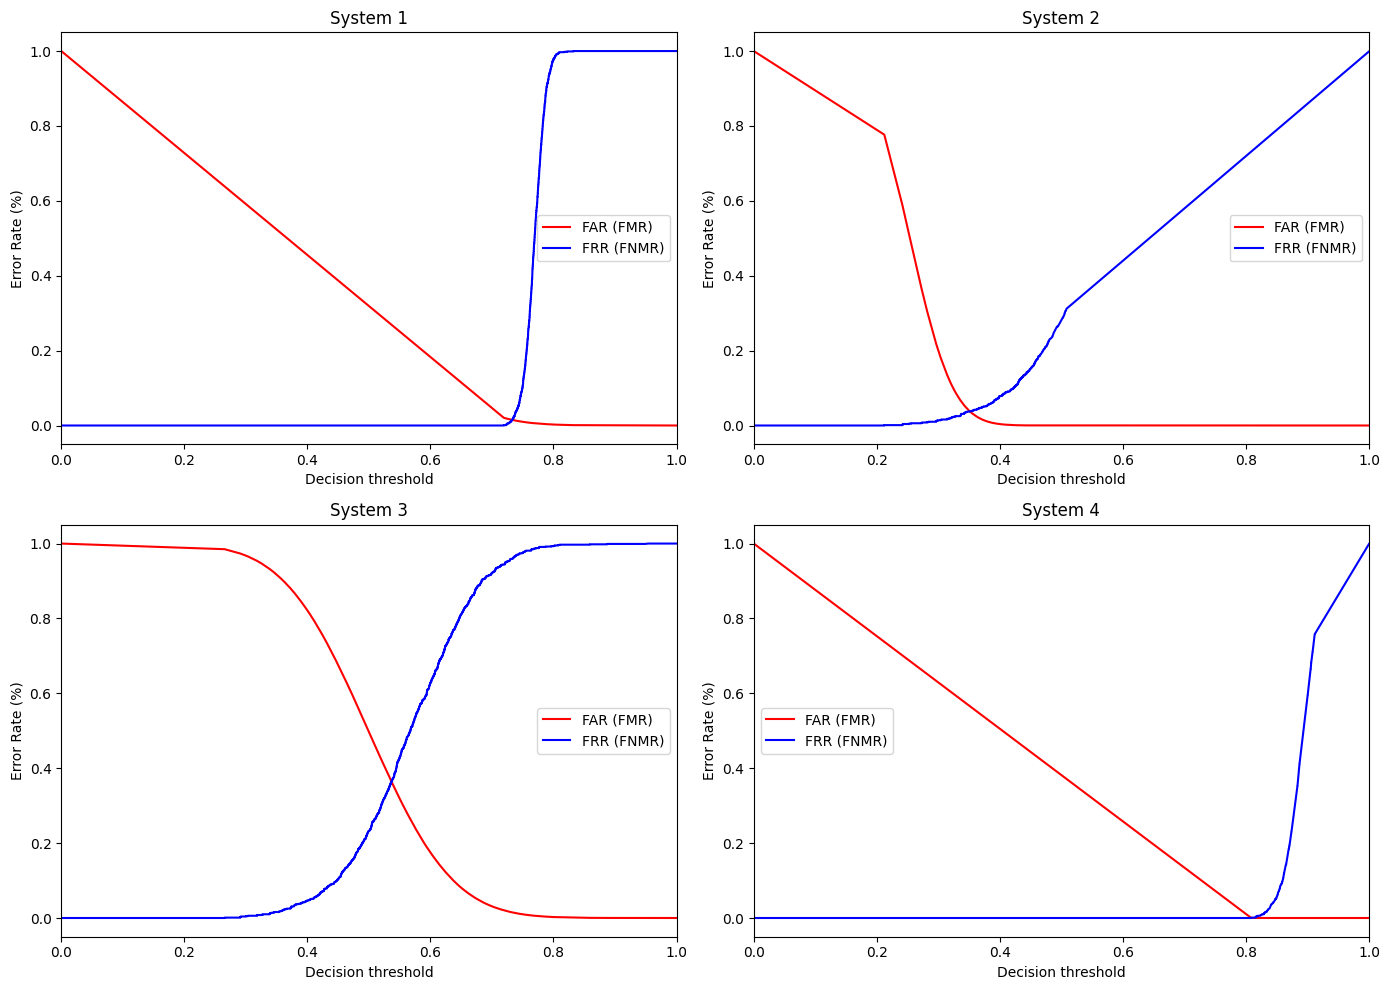

In [6]:
"""Plot FAR and FRR as a function of the decision threshold."""
# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, _, _) in enumerate(systems_list):
    fpr = fpr_dict[name]
    fnr = 1 - tpr_dict[name] # FRR = 1 - TPR
    thresholds = thresholds_dict[name]
    
    axes[i].plot(thresholds, fpr, label='FAR (FMR)', color='red')
    axes[i].plot(thresholds, fnr, label='FRR (FNMR)', color='blue')
    
    axes[i].set_title(name)
    axes[i].set_xlabel('Decision threshold')
    axes[i].set_ylabel('Error Rate (%)')
    axes[i].set_xlim([0, 1])
    axes[i].legend()

plt.tight_layout()
plt.show()

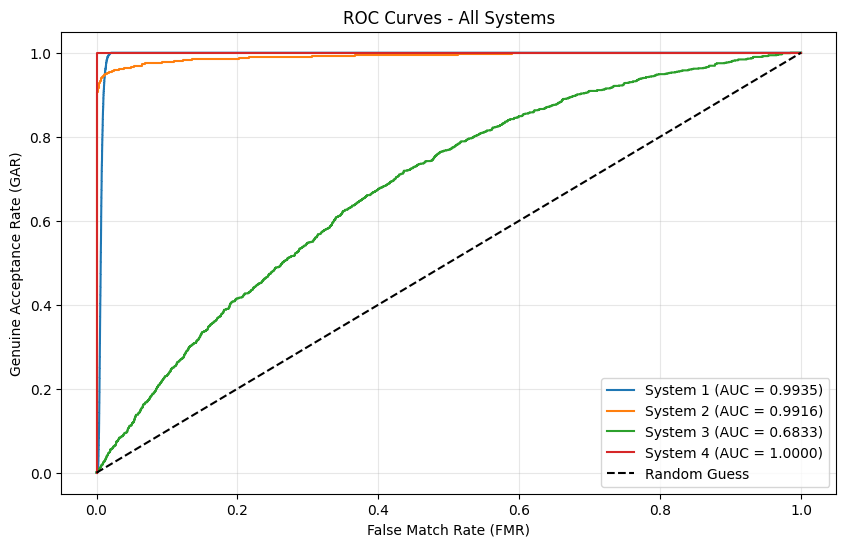

In [7]:
"""plot the ROC curve (TPR against the FPR for different threshold values)"""
plt.figure(figsize=(10, 6))

for name, _ , _ in systems_list:
    plt.plot(fpr_dict[name], tpr_dict[name], label=f'{name} (AUC = {auc_dict[name]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curves - All Systems')
plt.xlabel('False Match Rate (FMR)')
plt.ylabel('Genuine Acceptance Rate (GAR)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

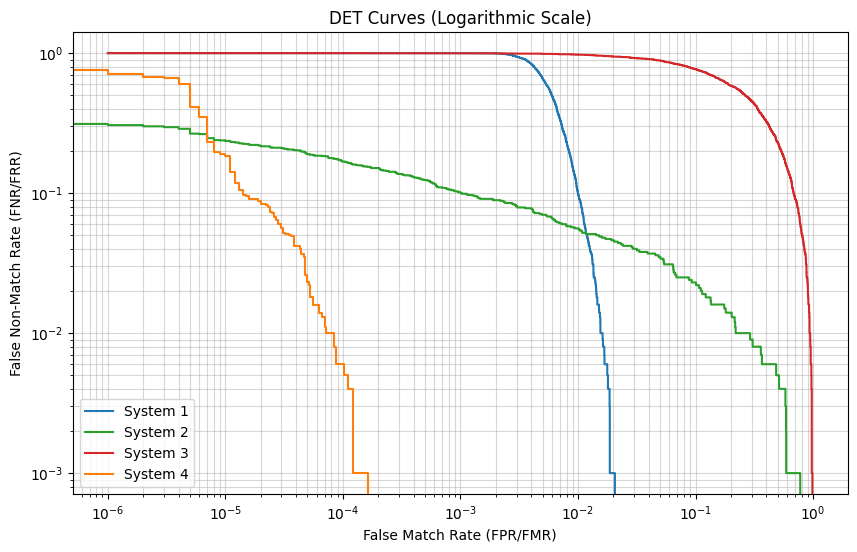

In [8]:
"""plot the DET curve (FRR (=1-tpr) against the FAR for different threshold values)"""

# FAR <=> FPR
# FRR <=> FNR <=> FN/P <=> 1-TPR

# Redefine the list with exactly 4 items per entry
systems_list = [
    ("System 1", system1_scores, system1_genuine_id, 'tab:blue'),
    ("System 2", system2_scores, system2_genuine_id, 'tab:green'),
    ("System 3", system3_scores, system3_genuine_id, 'tab:red'),
    ("System 4", system4_scores, system4_genuine_id, 'tab:orange')
]

plt.figure(figsize=(10, 6))
for name, scores, labels, color in systems_list:
    # Notice the 4 variables in the loop above: name, scores, labels, color
    fpr, fnr, _ = det_curve(labels, scores)
    plt.plot(fpr, fnr, label=name, color=color)

# Setting log scales is essential for DET curves to look correct
plt.yscale('log')
plt.xscale('log')
plt.title('DET Curves (Logarithmic Scale)')
plt.xlabel('False Match Rate (FPR/FMR)')
plt.ylabel('False Non-Match Rate (FNR/FRR)')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

#### 3. F1 and accuracy as metrics

While biometric systems are, traditionally, evaluated using FMR and FRR and ROC/DET curves, we can also have a look at traditional [classification metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) such as classification accuracy (or error) and F1 measure. 

<div class="alert alert-block alert-success">
<b>Q3: </b> Classification Metrics
<ul>
    <li>Plot F1 and accuracy as a function of the decision thresholds on the similarity score for the four systems<b> in a single plot </b>.</li>
    <li>Calculate the threshold and accuracy for which F1 is maximal. Is it an interesting operating point?</li>
    <li>Calculate the threshold and F1 for which accuracy is maximal. Is it an interesting operating point? Is there a difference with the results of the previous question and why?</li>
    <li>Is accuracy a good performance metric in this case?</li>
</ul>  
</div>

<div class="alert alert-block alert-info">
<b>Tip:</b> 
We highly recommend you use the <a href="https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics">scikit-learn classification metrics</a> to assist.
</div>


In [ ]:
"""Plot F1 and accuracy as a function of the decision thresholds on the similarity score."""
# Hint: evaluating for ± 50 threshold values should suffice

plt.figure(figsize=(15, 10))

for i, (name, scores, labels, color) in enumerate(systems_list):
    # Calculate Precision, Recall, and Thresholds
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Accuracy over a range of thresholds for a smooth curve
    eval_thresholds = np.linspace(0, 1, 100)
    accuracies = [accuracy_score(labels, scores >= t) for t in eval_thresholds]
    
    plt.subplot(2, 2, i+1)
    plt.plot(thresholds, f1_scores[:-1], label='F1 score', color=color, linewidth=2)
    plt.plot(eval_thresholds, accuracies, label='Accuracy', color='black', linestyle='--')
    
    plt.title(f'System Metrics: {name}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
"""Calculate the threshold for which F1 is maximal."""
for name, scores, labels, color in systems_list:
    precision, recall, thresholds = precision_recall_curve(labels, scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find the index of the best F1 score
    idx = np.argmax(f1_scores)
    max_f1 = f1_scores[idx]
    best_thresh = thresholds[idx]
    
    # Calculate accuracy at this specific F1-optimized threshold
    acc = accuracy_score(labels, scores >= best_thresh)
    
    print(f"{name:<12} | {max_f1:<10.4f} | {best_thresh:<10.4f} | {acc:<10.4f}")

In [ ]:
"""Do the same for the accuracy"""
for name, scores, labels, color in systems_list:
    # Test a fine grid of thresholds to find the peak accuracy
    test_thresholds = np.linspace(0, 1, 1000)
    accuracies = [accuracy_score(labels, scores >= t) for t in test_thresholds]
    
    idx = np.argmax(accuracies)
    max_acc = accuracies[idx]
    best_thresh = test_thresholds[idx]
    
    # Calculate F1 score at this specific accuracy-optimized threshold
    f1 = f1_score(labels, scores >= best_thresh)
    
    print(f"{name:<12} | {max_acc:<10.4f} | {best_thresh:<10.4f} | {f1:<10.4f}")

#### 4. AUC and EER as summary measures

The overall performance (over all threshold settings) is typically expressed through:

* The Area Under the Curve (AUC) (with TPR((y-axis) vs FPR (x-axis))

<img src="img/AUC.png" width="250" height="auto"/>

The AUC can be used to compare different systems. The larger this number, the better.
However, since it is a summary measure, always inspect the full ROC curve to make decisions about performance given operating conditions (in wich FRR, FAR regime to work e.g.).

* The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance. 

<img src="img/EER.png" width="300" height="300"/>

<div class="alert alert-block alert-success">
<b>Q4: </b> AUC, EER and alternatives
<ul>
    <li>Calculate ROC AUC. Is this a good metric? What does it reveal about the system? </li>
    <li>Calculate (by approximation) the EER and plot it on the FAR-FRR curve. Is this a good peration point?</li>
    <li>Calculate the decision threshold for which the sum of FRR and FAR is minimal. Is this point similar to the total classification error?</li> 
    <li>Discuss the importance of the FRR and the FAR if you want a very secure versus a very convenient system. </li> 
</ul>  
</div>


In [ ]:
"""Calculate the ROC AUC."""


In [ ]:
"""Calculate (by approximation) the EER and plot it on the FAR-FRR curve."""
# hints:
#  - avoid using a library that directly computes the EER for this assignment 


In [ ]:
"""Calculate the decision threshold for which the sum of FRR and FAR is minimal."""
# hint: same as above


#### 5. Evaluation using Precision and Recall

[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)
[3]: <https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision> (Average precision)

In a general binary classification setting, one also often presents Precision-Recall curves. PR-curves are sometimes summarized using the [average precision scores][3]. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c).  

Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code below from this [link][2], it also provides an implementation of the [average precision scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score).


<div class="alert alert-block alert-success">

<b>Q5: </b> Precision-Recall curves and related summary measures
<ul>
    <li>Calculate and plot the Precision-Recall curve for these systems. What does it reveal about the performance of the systems?</li>
    <li>Does the ROC curve or the PRC curve make more sense to evaluate these four systems? (Tip: read the webpages mentioned above). </li>
    <li>Calculate the Area Under the PR-curve. Discuss.</li>
    <li>Calculate the average precision scores. Discuss its value.</li> 
</ul>  
</div>


In [ ]:
"""Calculate and plot the Precision-Recall curve for the systems"""


In [ ]:
"""Calculate the Area Under the PR-curve."""


In [ ]:
"""Calculate the average precision scores"""


## III. Validation of identification system 

### Evaluation using CMC curves
In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 

<img src="img/CMC.jpg" width="500" height="auto"/>

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test sample. In our example we can easily calculate it from the similarity matrix (note that in this very particular case we have only one genuine pair per test sample). 



<div class="alert alert-block alert-success">
<b>Q6: </b> CMC curves
<ul>
    <li>Calculate the Cumulative Matching Characteristic curve (implement this yourself)</li>
    <li>Compute the Rank-1 Recognition Rate.</li>
</ul>  
</div>


In [ ]:
"""Calculate the Cumulative Matching Characteristic curve."""
# Hint: don't use a library


In [ ]:
"""compute the Rank-1 Recognition Rate."""


<div class="alert alert-block alert-success">
<b>Q7: </b> Evaluate different biometric systems
<ul>
    <li>Propose a new metric not mentioned in this task to evaluate these four systems. This can be something you come up with yourself by adjusting/combining some of the existing metrics in this task or something you find online. Explain in what way your new method is more/less suited to evaluate these systems </li>
</ul>  
</div>

## IV. Assignment Instructions

For the submission deadlines consult the slides in the “practical info module” on Toledo.

For the guidelines and submission instructions consult "Assignments/Guidelines/" on Toledo.

